Title: Distance Transform
Author: Thomas Breuel
Institution: UniKL

In [20]:

from scipy.ndimage import filters
def ims(image,**kw):
    size = kw.get("s",8)
    if "s" in kw: del kw["s"]
    subplots(1,1,figsize=(size,size))
    gray(); imshow(image,**kw)
def imp(image,**kw):
    subplots(1,1,figsize=(6,6))
    gray(); imshow(image,interpolation='nearest',**kw)
def imrow(*args,**kw):
    size = kw.get("s",8)
    if "s" in kw: del kw["s"]
    n = len(args)
    gray()
    subplots(1,n,figsize=(n*size,size))
    for i,im in enumerate(args):
        subplot(1,n,i+1); imshow(im,**kw)
def rescale(image):
    return (image-amin(image))/max(1e-4,amax(image)-amin(image))

Distance Transform via Grayscale Morphology
============================================

In nonlinear filters, we considered a special kind of grayscale operation:
morphological filtering with a filter constructed from the distance
from the central pixel. Let us look at this on a much simpler image.



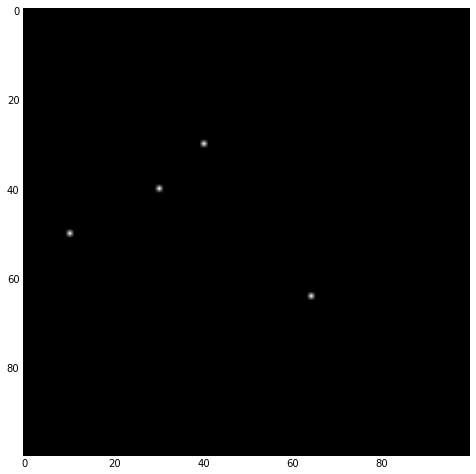

In [21]:
image = zeros((100,100))
image[64,64] = 1
image[30,40] = 1
image[40,30] = 1
image[50,10] = 1
imrow(image)

We now construct a mask in which each pixel value gives the distance from the central pixel.



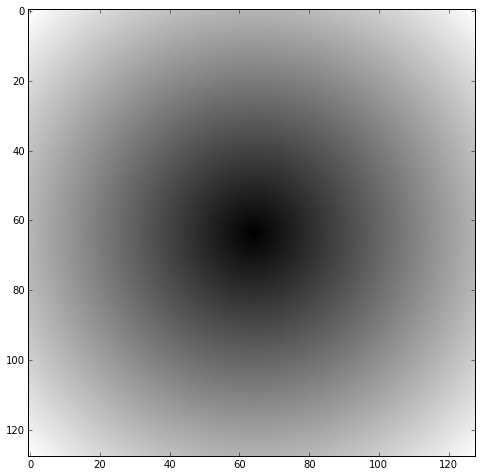

In [24]:
ys,xs = mgrid[:128,:128]
r = hypot(ys-64,xs-64)
imrow(r)

This expression will compute the distance transform now.



(128, 128)


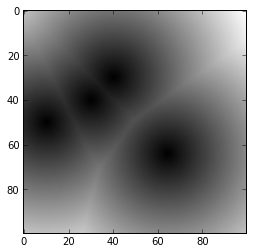

In [26]:
from scipy.ndimage import morphology,filters
print r.shape
dt = morphology.grey_erosion((1-image)*amax(r),size=r.shape,structure=-r)
imshow(dt)

In [27]:
print amin(dt),amax(dt)

0.0 66.1891229735


(explanation)

How does this work?

- we start with an image having zero at the sources and a large value elsewhere
- at a given location, we subtract the structuring element from each surrounding value
- at zero pixels, this gives the distance from the center of the mask
- elsewhere, it gives a large value
- the minimum over the mask is then the closest distance to a zero pixel

If you look at the output image (ignoring the top left and bottom left corners),
the gray values are proportional to the minimum distance of each pixel from
the white pixels in the original image.
That is because we effectively placed a mask on each original white pixel,
and assigned as the output value the minimum of the values in the overlapping masks,
where each value represents the distance to the center of the mask.

This is a common and very useful operation, but there are much more efficient
ways of computing it.

Distance Transform via the Brushfire Algorithm
=============================================

The operation we hinted at above is called the *Euclidean distance transform*.
It assigns, to each input pixel, the distance of that pixel from the nearest
white (or black, depending on the definition) input pixel.
Here is an illustration of that.



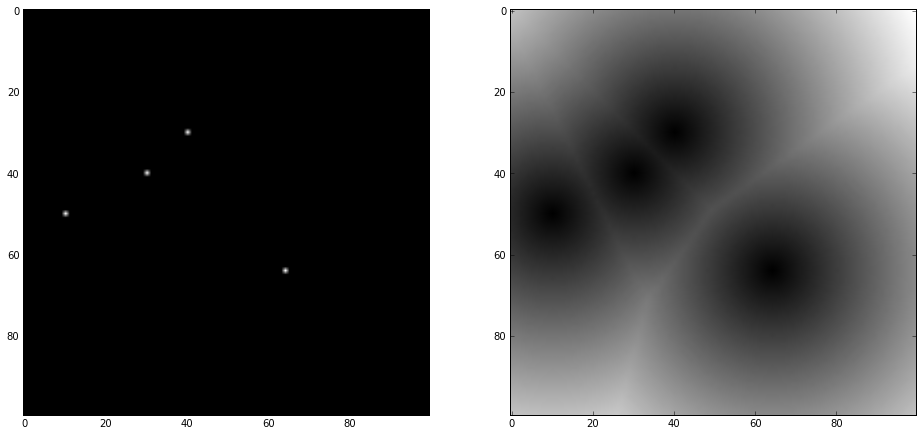

In [28]:
imrow(image,morphology.distance_transform_edt(1-image))

This is closely related to the Voronoi diagram in computational geometry.
In fact, we can see this connection more closely by performing a *feature transform*.
Here, not the distance, but the coordinates of the source pixel, are returned.



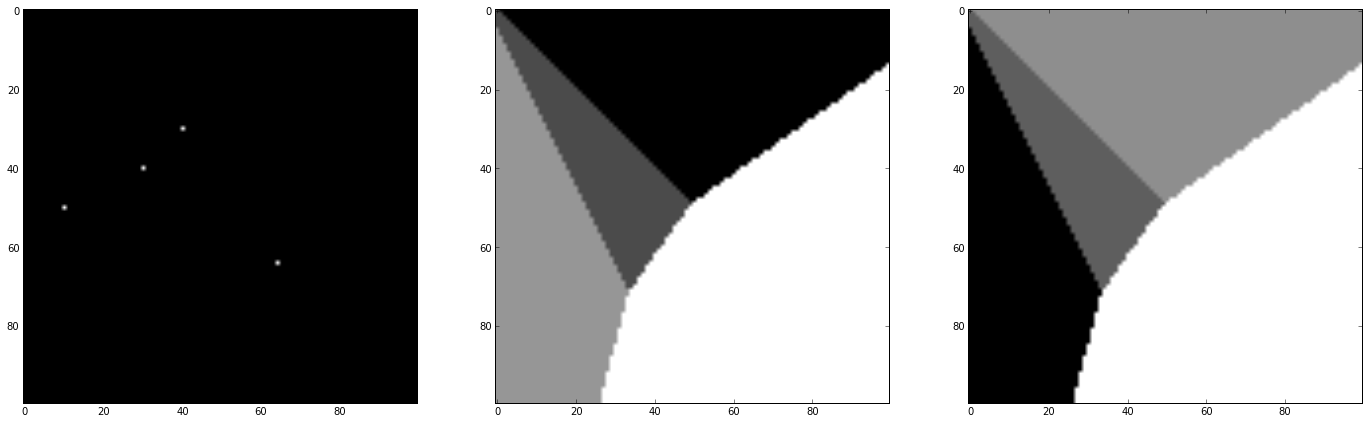

In [29]:
ix = morphology.distance_transform_edt(1-image,return_indices=1,return_distances=0)
imrow(image,ix[0],ix[1])

If we just want the Voronoi region corresponding to the source pixel at (64,64), we can ask for it as follows.



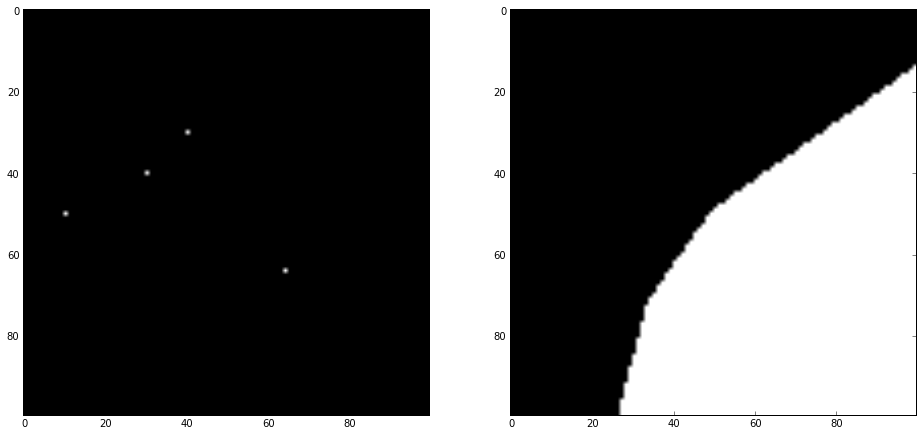

In [30]:
imrow(image,(ix[0]==64)*(ix[1]==64))

The Euclidean distance transform is closely related to binary morphological operations
with circular structuring elements: the latter are simply a thresholding of the former.



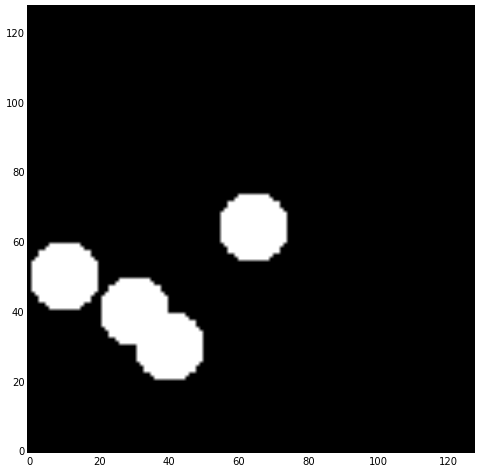

In [25]:
imrow(morphology.distance_transform_edt(1-image)<10)

# Brushfire Algorithm

Let's look at how the brushfire algorithm is implemented. 

We start with some useful variables and coordinate arrays.



In [126]:
h,w = image.shape
ys,vs = mgrid[:h,:w]

During the algorithm, we keep track of the source of each pixel (the closest "on" pixel) in the `sources` array.

We also keep track of the shortest distance to a particular point so far in the `dists` array (initialized to a large value).



In [127]:
sources = 9999999*ones((h,w,2))
dists = 9999999*ones((h,w))

At the location of the source pixels, the `sources` is the coordinates of the pixel itself and the distance is zero.



In [128]:
for u,v in zip(ys[image>0],xs[image>0]):
    sources[u,v,0] = u
    sources[u,v,1] = v
    dists[u,v] = 0

We build a little iterator to find the neighbors of a current pixel.



In [129]:
def neighbors(p):
    for i in range(-1,2):
        for j in range(-1,2):
            q = array([i,j])+p
            if i==0 and j==0: continue
            if amin(q)<0: continue
            if q[0]>=h: continue
            if q[1]>=w: continue
            yield q            

We also need a FIFO queue.



In [130]:
class FIFO:
    def __init__(self):
        self.left = []
        self.right = []
    def __len__(self):
        return len(self.left)+len(self.right)
    def push(self,x):
        self.left.append(x)
    def pop(self):
        if len(self.right)<1:
            while(len(self.left)>0): self.right.append(self.left.pop())
        return self.right.pop()

We initialize the FIFO queue with the initial pixels in the source array.

This says that the neighbors of these pixels need to be updated.



In [131]:
fifo = FIFO()
for p in zip(ys[image>0],xs[image>0]):
    fifo.push(p)

The main loop of the algorithm takes a pixel from the queue of pixels whose neighbors need to be updated, and then checks whether we have found a shorter path to any neighbors than we previously knew about. If yes, we update its info and add the new pixel to the queue.



In [132]:
while len(fifo)>0:
    p = fifo.pop()
    source = sources[p[0],p[1]]
    for q in neighbors(p):
        ndist = norm(q-source)
        if ndist<dists[q[0],q[1]]:
            y,x = q
            dists[y,x] = ndist
            sources[y,x,0] = source[0]
            sources[y,x,1] = source[1]
            fifo.push(q)

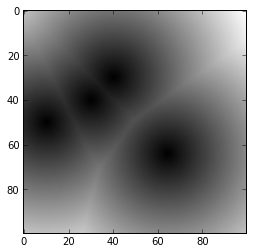

In [133]:
imshow(dists)

Some comments on this algorithm:

- this is a serial implementation, the way you would write it in C
- you can write faster array-based implementations
- there are some faster algorithms for implementing distance transform

The algorithm assumes that all pixels within a Voronoi cell are path connected to the source; this assumption is not true for a few pixels. There are fixes for this that make the algorithm a little more complicated.

# Other Applications

Euclidean distance transformations have many uses outside strict image processing.
For example, here is a simple application to robot navigation.

Assume we have a circular robot platform and we want to see where that
platform can navigate on a floorplan.

We start by reading in the floorplan as an image.



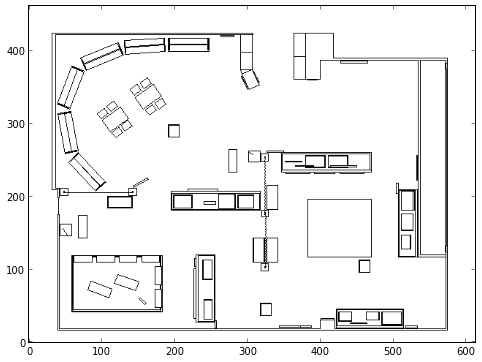

In [45]:
floorplan = mean(imread("floorplan.png"),axis=2)
floorplan = (floorplan>amax(floorplan)/2.0)
imrow(floorplan)

Now the distance transform gives us the distance of each floor pixel from some obstacle. A circular robot platform of radius 15 pixels cannot navigate closer than 15 pixels to any obstacle. As we can see from the thresholded image, a robot can navigate every room of the exhibit, but it cannot get behind the structure in the bottom left.



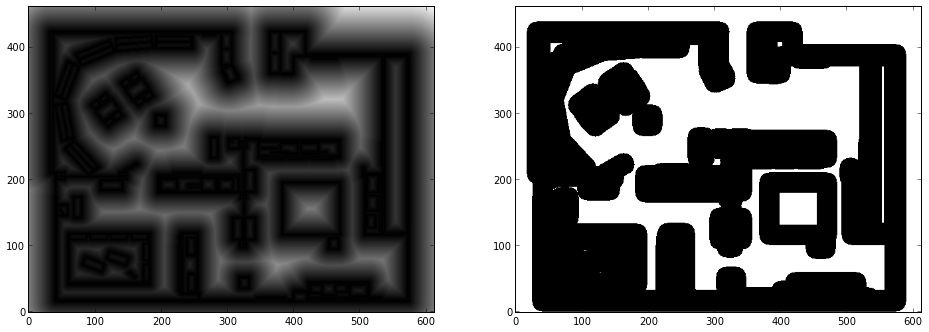

In [46]:
dt = morphology.distance_transform_edt(floorplan)
imrow(dt,dt>15)

Of course, we could have obtained the same result with a morphological operation,
using the footprint of the robot as the mask.
However, the distance transform actually gives us the locally best
place to navigate in order to stay as far away from the walls as possible
(the *medial axis transform*).

Such computations are often carried out using polygonal approximations in
computational geometry.
The resulting computational geometry algorithms can become quite complex
and spend a lot of resources on computing sub-pixel effects.
On the other hand, they are resolution independent and can
cope more easily with rotations.